# **COMP8220 Major Project**
## **Final Report for Face Emotions Recognition**

**Kaggle User Name: RonnieHui**

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Introduction**

This notebook is for the major project submission for COMP8220, on the Face Emotions Recognition dataset and task. It contains the following sections:

*   Data exploration and image preprocessing
*   Selected conventional ML model
*   Selected deep learning model
*   Comparison between the two model 
*   Conclusion



# **Data Exploration and Image Preprocessing:**




The Face Only dataset consist of 9328 face images with emotion labels and thte OOD dataset consist of 1500 MNIST images with digit labels on top of the Face Only dataset (a total of 10828 images). The tasks are to train a convential ML Model and a deep learning model to predict face emotions including **angry, disgusted, fearful, happy, say, surprised and neutral**. MNIST images are classified as **OTHER** in the OOD dataset. The below image shows an example of the training images in the shuffled OOD dataset.

<img src="https://i.ibb.co/Y3DC0HK/Screenshot-2022-06-01-at-6-27-36-PM.png" alt="Screenshot-2022-06-01-at-6-27-36-PM" border="0" width="400">

Dsitribution of emotions in the datasets were shown in the pie charts below. It is observed that images for disgusted was much less than the other emotions, counting only 2% of all images in both Face Only and OOD dataset.

<img src="https://i.ibb.co/fNQw7k5/Screenshot-2022-06-02-at-1-14-45-PM.png" alt="Screenshot-2022-06-02-at-1-14-45-PM" border="0">



## **Import Libraries**

In [19]:
# import necessary libraries
import pandas as pd
import numpy as np
import os

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# import HOG
from skimage.feature import hog

# import image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import libraries for SVM 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# import libraries for deep learning
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# import sklearn libraries for evaluations
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import libraries for plotting 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

## **Read the Data**

Face Only dataset and OOD dataset are handled separately.


### **Handle data for Face Only**

In [20]:
from os.path import join

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral', 'OTHER']
dataset_directory = '/content/drive/MyDrive/COMP8220/Major Project/data'

# load npy data
images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))
images_test_public_face = np.load(join(dataset_directory, 'PublicTest_faces_only_data_images.npy')) 
images_test_private_face = np.load(join(dataset_directory, 'PrivateTest_data_images.npy')) 

# reshape data
images_train = images_train.reshape([-1, image_size, image_size])
images_test_public_face = images_test_public_face.reshape([-1, image_size, image_size])   
images_test_private_face = images_test_private_face.reshape([-1, image_size, image_size])   

print(images_train.shape)
print(labels_train.shape)
print(images_test_public_face.shape)
print(images_test_private_face.shape)

(9328, 48, 48)
(9328,)
(1136, 48, 48)
(1153, 48, 48)


In [21]:
sample = 0
print(images_train[sample])
print(labels_train[sample])
print(EMOTIONS[labels_train[sample]]) # match emotions with labels

[[0.25098039 0.24705882 0.2745098  ... 0.16078431 0.2        0.21960784]
 [0.22745098 0.19215686 0.20784314 ... 0.14509804 0.16470588 0.18823529]
 [0.12941176 0.14901961 0.16862745 ... 0.17254902 0.21568627 0.20784314]
 ...
 [0.14117647 0.19215686 0.23137255 ... 0.19607843 0.22352941 0.25882353]
 [0.12156863 0.12941176 0.18431373 ... 0.2627451  0.26666667 0.23137255]
 [0.14901961 0.09019608 0.09803922 ... 0.37254902 0.26666667 0.21568627]]
0
angry


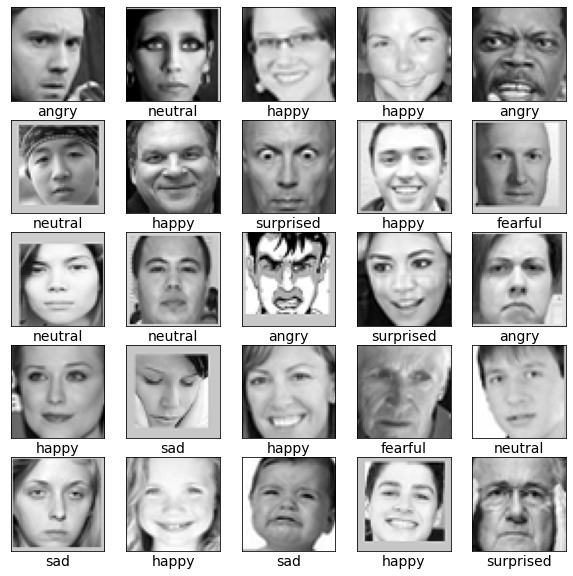

In [22]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel(EMOTIONS[labels_train[i]])
plt.show()

In [23]:
# make labels into data frame
import pandas as pd
df_labels = pd.DataFrame(labels_train, columns = ['labels']) # use label_train for face only data
df_labels.head()

,labels
0,0
1,6
2,3
3,3
4,0


In [24]:
# Create a Dictionary for emotions
emotions_labels = {
0:'angry',
1:'disgusted',
2:'fearful',
3:'happy',
4:'sad',
5:'surprised',
6:'neutral',
7: 'OTHER',
}

In [25]:
# Create a new Column matching Dictionary value
df_labels['emotions'] = df_labels['labels'].map(emotions_labels)
df_labels.head()

,labels,emotions
0,0,angry
1,6,neutral
2,3,happy
3,3,happy
4,0,angry


In [26]:
df_labels['emotions'].value_counts()

happy        2736
neutral      1913
angry        1266
fearful      1107
surprised    1052
sad          1043
disgusted     211
Name: emotions, dtype: int64

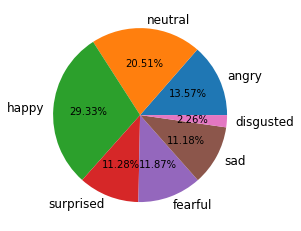

In [27]:
plt.pie(df_labels['emotions'].value_counts(sort=False),labels=df_labels['emotions'].unique(),autopct = '%1.2f%%')
plt.show()

### **Handle data for OOD** 

Since MNIST data labels are digits of 0 - 9, I have changed all mnist labels to others[7] so it won't mix up with the emotions label.

In [28]:
# load npy data
images_train_ood = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train_ood = np.load(join(dataset_directory, 'Training_data_labels.npy'))
images_mnist = np.load(join(dataset_directory, 'MNIST_dev_data_images.npy')) 
labels_mnist = np.load(join(dataset_directory, 'MNIST_dev_data_labels.npy')) 
images_test_public_ood = np.load(join(dataset_directory, 'PublicTest_faces_plus_data_images.npy'))
images_test_private_ood = np.load(join(dataset_directory, 'PrivateTest_faces_plus_data_images.npy')) 

# reshape data
images_train_ood = images_train.reshape([-1, image_size, image_size])
images_mnist = images_mnist.reshape([-1, image_size, image_size])
images_test_public_ood = images_test_public_ood.reshape([-1, image_size, image_size])  
images_test_private_ood = images_test_private_ood.reshape([-1, image_size, image_size]) 
labels_mnist = labels_mnist.reshape(1500) 

print(images_train_ood.shape)
print(labels_train_ood.shape)
print(images_mnist.shape) 
print(labels_mnist.shape) 
print(images_test_public_ood.shape)
print(images_test_private_ood.shape)

(9328, 48, 48)
(9328,)
(1500, 48, 48)
(1500,)
(1636, 48, 48)
(1753, 48, 48)


In [29]:
# 
# change all mnist labels to others[7] so it won't mix with emotions label
labels_mnist = np.where(labels_mnist >=0, 7, labels_mnist)
labels_mnist 
# no MNIST for face only data

array([7, 7, 7, ..., 7, 7, 7])

In [30]:
# combine images with MNIST
images_all = np.concatenate((images_train_ood, images_mnist))
# use image_train for face only data

In [31]:
# combine image labels with MNIST labels
labels_all = np.concatenate((labels_train_ood, labels_mnist))
# use label_train for face only data

In [32]:
sample = 0
print(images_all[sample])
print(labels_all[sample])
print(EMOTIONS[labels_all[sample]]) # match emotions with labels

[[0.25098039 0.24705882 0.2745098  ... 0.16078431 0.2        0.21960784]
 [0.22745098 0.19215686 0.20784314 ... 0.14509804 0.16470588 0.18823529]
 [0.12941176 0.14901961 0.16862745 ... 0.17254902 0.21568627 0.20784314]
 ...
 [0.14117647 0.19215686 0.23137255 ... 0.19607843 0.22352941 0.25882353]
 [0.12156863 0.12941176 0.18431373 ... 0.2627451  0.26666667 0.23137255]
 [0.14901961 0.09019608 0.09803922 ... 0.37254902 0.26666667 0.21568627]]
0
angry


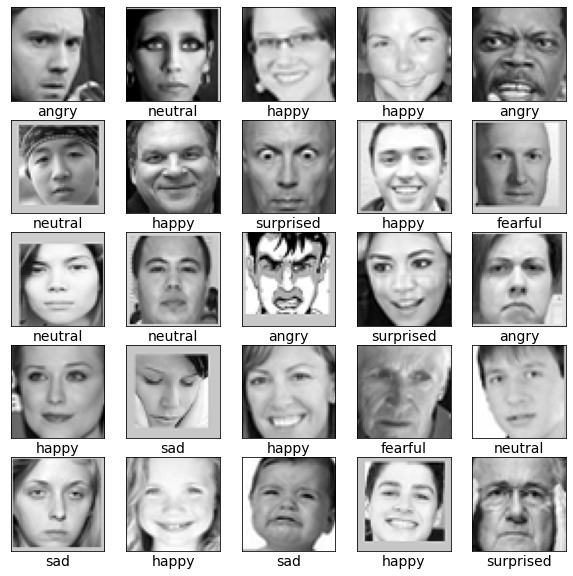

In [33]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_all[i], cmap='gray') # use image_train for face only data
    plt.xlabel(EMOTIONS[labels_all[i]])
plt.show()

In [34]:
# make labels into data frame
import pandas as pd
ood_labels = pd.DataFrame(labels_all, columns = ['labels']) # use label_train for face only data
ood_labels.head()

,labels
0,0
1,6
2,3
3,3
4,0


In [35]:
# Create a new Column matching Dictionary value
ood_labels['emotions'] = ood_labels['labels'].map(emotions_labels)
ood_labels.head()

,labels,emotions
0,0,angry
1,6,neutral
2,3,happy
3,3,happy
4,0,angry


In [36]:
ood_labels['emotions'].value_counts()

happy        2736
neutral      1913
OTHER        1500
angry        1266
fearful      1107
surprised    1052
sad          1043
disgusted     211
Name: emotions, dtype: int64

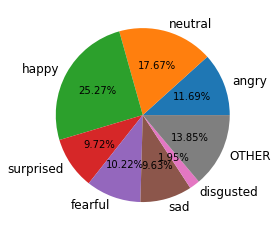

In [37]:
plt.pie(ood_labels['emotions'].value_counts(sort=False),labels=ood_labels['emotions'].unique(),autopct = '%1.2f%%')
plt.show()

## **Image Preprcoessing: Histogram of Oriented Gradients Method**

***NOTE:*** *HOG was applied to training conventional ML models only as it does not work well in deep learning models.*

I applied **histogram of oriented gradients (HOG)** method, which is an effective descriptor for object recognition and detection, to preprocess the images. According to Sharon Morris, "*an image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, **cells are block normalized**, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The **HOG feature vector for the image is the concatenation of these cell-level histograms**.*"
[Reference: [Image Classification Using SVM](http://rstudio-pubs-static.s3.amazonaws.com/454441_79ebb625c3ee47a18f88c61490f43c22.html)]

After applying HOG, the **image features are reduced to 1296** instead of 2304 of the original features. The image below shows how HOG transformed a sample image of the dataset from original on the left to the one on the right.

<img src="https://i.ibb.co/34cv2CF/Screenshot-2022-06-01-at-6-11-30-PM.png" alt="Screenshot-2022-06-01-at-6-11-30-PM" border="0" width="400">



### Create image features and flatten into a single row


In [38]:
def create_features(img):
    # define hog
    hog_features = hog(img, block_norm='L2-Hys', pixels_per_cell=(8, 8))
    return hog_features

In defining HOG, I have tried to manipulate the `pixels_per_cell = (2,2) , (4,4) and (8,8)`. I found out the `pixels_per_cell=(8,8)` produces the best result in terms of efficeincy and accuracy. Setting `pixels_per_cell = (2,2) or (4,4)` did not produce better accuracy and even increase processing time. I suspected it is due to small image size of the original images, and breaking the block cells into even smaller cells will loss too many image features. Therefore, I eventually defined the create_features fuction with `pixels_per_cell=(8, 8)`.

### Loop over images for preprocessing

In [39]:
# create features for each image and then stack the flattened features arrays into a big matrix we can pass into our model.

def create_feature_matrix(images):
    features_list = []
    
    for i in range(len(images)):
        # load image
        img = images[i]
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

In [40]:
# run create_feature_matrix on our dataframe of images
feature_matrix_ood = create_feature_matrix(images_all) # OOD
feature_matrix_face = create_feature_matrix(images_train) #face only

In [41]:
# get shape of feature matrix
print('Feature matrix shape for face only is: ', feature_matrix_face.shape)
print('Feature matrix shape for OOD is: ', feature_matrix_ood.shape)

Feature matrix shape for face only is:  (9328, 1296)
Feature matrix shape for OOD is:  (10828, 1296)


## **Image Preprcoessing: Image Data Generator**

I applied Image Data Generator to transform the images before training the deep learning models. After testing for a few combinations of the image augmentation, I set: `rescale=1.0/255.0, rotation_range=15 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True` which provided the best accuracy in the final model. Note that `rescale=1.0/255.0` is to normalize the image. Below are some example of transformed image. (zoom=crop)

<img src="https://i.ibb.co/LYt37dG/Screenshot-2022-06-01-at-6-07-12-PM.png" alt="Screenshot-2022-06-01-at-6-07-12-PM" border="0" width="600">


The code to transform image is as below. It will be used in training deep learning models.

```
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
```



## **Discussion on other Data Preprocessing Approaches**

### **1. Scale up disgusted images**

Since disgusted images is only around 2% of the dataset, I tried to duplicated the images of disgusted emotion for 1-5 times, then applied HOG and run the models to check if it improve accuracy. The **results are slightly better (0.01-0.02 increase in Public test accuracy)** than not scaling up disgusted images. However, I decided  not to use it becasuse although it slightly increased the accuracy on predicting disgusted images, **it reduced accuracy on predicting other emotions. Overall, the improvement is not significant.**

### **2. Reduce Dimensionality using PCA**

**Principal Component Analysis (PCA)** was not applied in the final model to reduce dimensionality because it resulted in **slightly decrease in accuracy** of when training the models. I suspected that it is mainly due to the small image size of the original images. After applying HOG, the images were already normalized and compressed, when PCA applied, it could have **reduced too much image features** and affected the result. By preserving 95% of its variance, PCA resulted in just 227 features, compare to 1296 features in HOG.


<img src="https://i.ibb.co/G0pD5dy/Screenshot-2022-06-01-at-5-54-56-PM.png" alt="Screenshot-2022-06-01-at-5-54-56-PM" border="0" width = "400">

# **Selected Conventional ML model - SVM**

In training the conventional model, the dataset was splitted into 80% training data and 20% testing data. Data was shuffled and **stratified sampling** applied. The selected conventional ML model that produced the best-performing predictions for the Kaggle submission in both the public test (accuracy 63% for Face Only and 72% for OOD) and private test (accuracy 64% for Face Only and 69% for OOD) was a **Support-Vector Machines (SVM) classifier** with setting of `SVC(kernel = "rbf", gamma = "auto", C = 100, probability=True)`.

### **Training the model for Face Only**

In [42]:
# train test split, stratify=y

X = feature_matrix_face
y = labels_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7462, 1296)
(7462,)
(1866, 1296)
(1866,)


In [44]:
# define the mdoel
svm_clf = Pipeline([("scaler", StandardScaler()),
                     ("svm_clf", SVC(kernel = "rbf", gamma = "auto", C = 100, probability=True))])
svm_clf.fit(X_train, y_train) # fit the model

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=100, gamma='auto', probability=True))])

In [45]:
# calculate cross validation scores for each fold:
cross_val_score(svm_clf, X_test, y_test, cv=5, scoring="accuracy")

array([0.55080214, 0.56300268, 0.57640751, 0.58176944, 0.5227882 ])

In [46]:
# make predictions on train set:

y_test_pred_svm = cross_val_predict(svm_clf, X_test, y_test, cv=5)

### **Evaluation**

In [47]:
print("Accuracy score:{:.2f}".format(accuracy_score(y_test, y_test_pred_svm)))
print("Precision score:",precision_score(y_test, y_test_pred_svm, average="weighted"))
print("Recall score:",recall_score(y_test, y_test_pred_svm, average="weighted"))
print("F1 score:", f1_score(y_test, y_test_pred_svm, average="weighted"))

Accuracy score:0.56
Precision score: 0.5497625131311019
Recall score: 0.5589496248660236
F1 score: 0.544457550914421


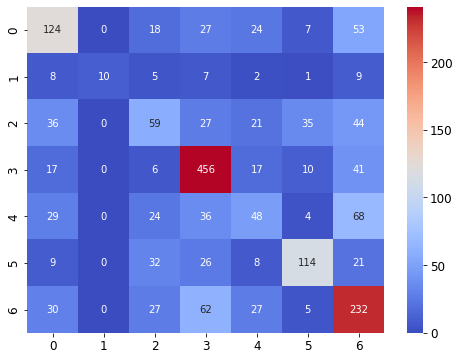

In [48]:
# plot heatmap 
plt.figure(1, figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_svm), cmap='coolwarm', robust=True, annot=True, fmt=".0f")

From the heatmap, it can be seen that SVM classifier is doing quite well on classifying happy and neutral but not so well on disgusted, fearful and sad. The accuracy score for the model is 0.56, precision score is 0.55, recall score is 0.56 and F1 score is 0.54.


### **Prediction on Public and Private Test**

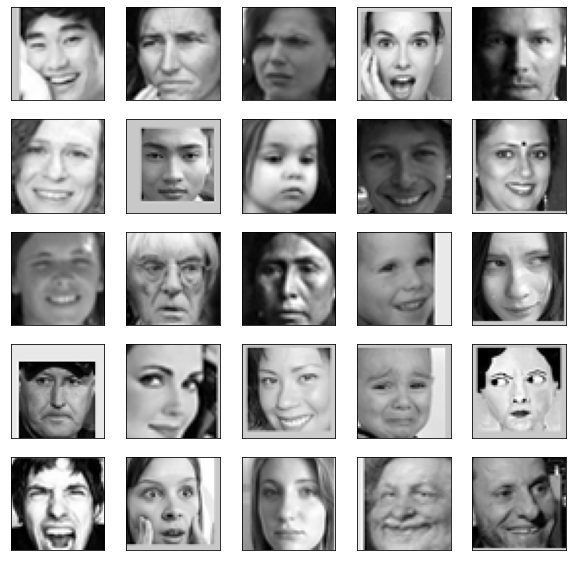

In [49]:
# show public images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public_face[i], cmap='gray')
plt.show()

In [50]:
# run create_feature_matrix on our dataframe of images
feature_matrix_public_face = create_feature_matrix(images_test_public_face)
feature_matrix_private_face = create_feature_matrix(images_test_private_face)

In [51]:
print('Public Feature matrix shape is: ', feature_matrix_public_face.shape)
print('Private Feature matrix shape is: ', feature_matrix_private_face.shape)

Public Feature matrix shape is:  (1136, 1296)
Private Feature matrix shape is:  (1153, 1296)


In [52]:
# make prediction
public_pred_svm = svm_clf.predict(feature_matrix_public_face)
private_pred_svm = svm_clf.predict(feature_matrix_private_face)
print(public_pred_svm)
print(private_pred_svm)

[3 6 3 ... 6 4 3]
[4 3 3 ... 6 3 2]


In [53]:
# Generate csvs for public test
f = open(join(dataset_directory, '46727000_conv_predictions_svm_public_face.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_public_face)):
  f.write(str(i) + f',{public_pred_svm[i]}\n') 
f.close()

In [54]:
# Generate csvs for private test
f = open(join(dataset_directory, '46727000_conv_predictions_svm_private_face.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_public_face)):
  f.write(str(i) + f',{private_pred_svm[i]}\n') 
f.close()

### **Training the model for OOD**

In [55]:
# train test split, stratify=y

X = feature_matrix_ood
y = labels_all
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8662, 1296)
(8662,)
(2166, 1296)
(2166,)


In [57]:
# define the mdoel
svm_clf = Pipeline([("scaler", StandardScaler()),
                     ("svm_clf", SVC(kernel = "rbf", gamma = "auto", C = 100, probability=True))])
svm_clf.fit(X_train, y_train) # fit the model

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=100, gamma='auto', probability=True))])

In [58]:
# calculate cross validation scores for each fold:
cross_val_score(svm_clf, X_test, y_test, cv=5, scoring="accuracy")

array([0.60138249, 0.6073903 , 0.59815242, 0.59122402, 0.61893764])

In [59]:
# make predictions on train set:

y_test_pred_svm_ood = cross_val_predict(svm_clf, X_test, y_test, cv=5)

### **Evaluation**

In [60]:
print("Accuracy score:{:.2f}".format(accuracy_score(y_test, y_test_pred_svm_ood)))
print("Precision score:",precision_score(y_test, y_test_pred_svm_ood, average="weighted"))
print("Recall score:",recall_score(y_test, y_test_pred_svm_ood, average="weighted"))
print("F1 score:", f1_score(y_test, y_test_pred_svm_ood, average="weighted"))

Accuracy score:0.60
Precision score: 0.5940408098778993
Recall score: 0.6034164358264081
F1 score: 0.5926155536752179


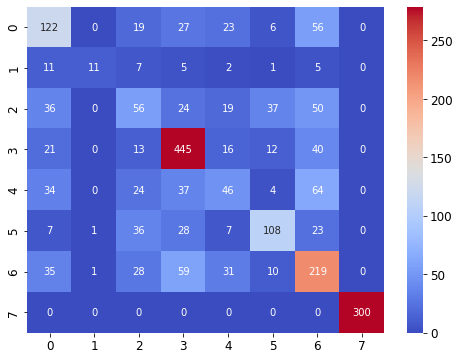

In [61]:
# plot heatmap 
plt.figure(1, figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_svm_ood), cmap='coolwarm', robust=True, annot=True, fmt=".0f")

From the heatmap, it can be seen that SVM classifier is doing quite well on classifying happy and neutral but not so well on disgusted, fearful and sad. It is 100% correct in classifying MNIST data. The Accuracy score is 0.60, Precision score: 0.59, 
Recall score is 0.6 and F1 score is 0.59. 

It is observed that SVM classifier performed better on OOD dataset than Face Only dataset.


### **Prediction on Public and Private Test**

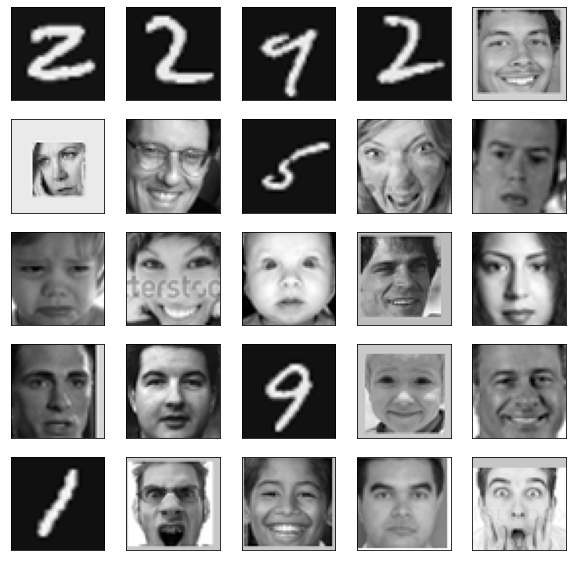

In [62]:
# show public images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public_ood[i], cmap='gray')
plt.show()

In [63]:
# run create_feature_matrix on our dataframe of images
feature_matrix_public_ood = create_feature_matrix(images_test_public_ood)
feature_matrix_private_ood = create_feature_matrix(images_test_private_ood)

In [64]:
print('Public Feature matrix shape is: ', feature_matrix_public_ood.shape)
print('Private Feature matrix shape is: ', feature_matrix_private_ood.shape)

Public Feature matrix shape is:  (1636, 1296)
Private Feature matrix shape is:  (1753, 1296)


In [65]:
# make prediction
public_pred_svm_ood = svm_clf.predict(feature_matrix_public_ood)
private_pred_svm_ood = svm_clf.predict(feature_matrix_private_ood)
print(public_pred_svm_ood)
print(private_pred_svm_ood)

[7 7 7 ... 2 7 7]
[6 7 6 ... 7 7 2]


In [66]:
# Generate csvs for public test
f = open(join(dataset_directory, '46727000_conv_predictions_svm_public_ood.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_public_ood)):
  f.write(str(i) + f',{public_pred_svm_ood[i]}\n') 
f.close()

In [67]:
# Generate csvs for private test
f = open(join(dataset_directory, '46727000_conv_predictions_svm_private_ood.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_private_ood)):
  f.write(str(i) + f',{private_pred_svm_ood[i]}\n') 
f.close()

### **Discussion on other Conventional ML Models trained**

|                                   | Face Only    |              | Face plus MNIST |              |
|-----------------------------------|--------------|--------------|-----------------|--------------|
|     **Conventional ML Model**         |     **Accuracy** |     **F1 Score** |     **Accuracy**    |     **F1 Score** |
|     SVM (selected)                | 0.55         | 0.54         |        0.61     |        0.59  |
| Ensemble(SVM+logistic Regression) | 0.54         | 0.52         | 0.6             | 0.58         |
| logistic Regression               | 0.51         | 0.5          | 0.58            | 0.57         |
| Random Forest                     | 0.49         | 0.42         | 0.56            | 0.49         |
|     SGD                           | 0.47         | 0.46         |        0.54     |        0.53  |
| ***-----Before Image Preprocessing-----***        |              |              |                 |              |
| Random Forest                     | 0.46         | 0.41         | 0.48            | 0.45         |
| logistic Regression               | 0.43         | 0.42         | 0.45            | 0.44         |
|     SVM                           | 0.4          | 0.4          |        0.49     |        0.47  |
|     SGD                           | 0.37         | 0.36         |        0.4      |        0.38  |

*Table 1: Summary Table for Conventional ML Models*

The above table summarized the accuracy and F1 scores for conventional ML models I trained in predicting face emotions and face emotions plus MNIST data respectively. It can been seen that **accuracy and F1 score greatly improved after image preprocessing for all trained models**. Moreover, all models performed better in predicting emotions with Face plus MNIST data than with Face only data. SVM is selected as it performed the best in predicting face emotions in both datasets.


**1. Random Forest Classifier**
* trained with a combination of `(n_estimators=1000, 3000, 5000, max_leaf_nodes=50, 100, 150, oob_score = True)`
* this classifier wrongly classified other emotions to happy and neutral to a larger extend than SVM

**2. Logistic Regression**
* trained with `(solver = 'lbfgs', max_iter=1000, 5000)`, with `max_iter=5000` generated better accuracy
* Overall, it performance is the second best

**3. SGD Classifier**
* trained with `(max_iter=1000, 5000)`
* Performance is the worst

**4. Ensemble Learning**
* tried to combine the classifiers to see if it can achieve higher accuracy.
* after trying different combination among *svm_clf, random_forest_clf, logreg_clf* and *sgd_clf*, the best ensemble model consists of *svm_clf* and *logreg_clf*. However, the accuracy rate is still smaller than purely using SVM classifier. 

# **Selected Deep Learning model - CNN**

In training the deep learning models, the dataset was splitted into 80% training data and 20% testing data. The first 1000 data from training set was set aside for validation. Data was shuffled and **stratified sampling** applied. 

The selected deep learning model that produced the best-performing predictions for the Kaggle submission in both the public test (accuracy 66% for Face Only and 74% for OOD) and private test (accuracy 63% for Face Only and 73% for OOD) was a **Convolutional Neural Networks (CNN) model**.

The sequential network model consisted of convolutional layers, batch normalizations, pooling layers, dropout layers, flatten layer and dense layers. The architecture used is:
```
Conv2D(filters=64,kernel_size=(3,3),input_shape=(48, 48, 1),activation='relu',padding='same'),
BatchNormalization(),
Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2,2)),
Dropout(0.5),
Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
BatchNormalization(),
Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2,2)),
Dropout(0.5),
Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
BatchNormalization(),
Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2,2)),
Dropout(0.5),
Flatten(),
Dense(128, activation="relu"),
BatchNormalization(),
Dropout(0.5),
Dense(8, activation="softmax")

```
### **Discussion on the layer construction:**
**1. 2D Convolution Layer**\
I tried to use *kernel size at 3x3, 5x5 or 7x7*. The result was **kernel size at 3x3** performed the best. It is because limiting the number of parameters, we are limiting the number of unrelated features possible. For activation, I tried to use *ReLU, eLU, Softplus, Softmax* and *Sigmoid* functions. The result was ReLU performed the best. Therefore, I use **ReLU with zero padding** in hidden layers to avoid vanishing gradient problem and better computation performance.

**2. Batch Normalization**\
I implemented batch normalization layers to **reduce the internal covariate shift and instability in distributions of layer activations** in Deeper networks and thus **reduce the effect of overfitting** and works well with generalization data. By adding batch normalization layers, the **accuracy increase by 10%** compared to models without batch normalization layers.

**3. Pooling Layer**\
I used pooling layers to **reduce the dimensions** of the feature maps. I chose **Max-Pooling** over Avg-pooling becasue Max-Pooling helps in extracting low-level features like edges, points and thus, perform better than Avg-pooling in this case.

**4. Dropout Layer**\
I used Dropout layer after each pooling to **prevent overfitting**.

**5. Dense Layer**\
I used **Softmax** function in the last layer to **normalize the output** to a probability distribution.

### **Loss Function and Optimizer:**
I set loss function to "**sparse_categorical_crossentropy**" and optimizer to '**Nadam**' in the selected model. Nadam performed better (around 5% increase in accuracy) than Adam optimizer during model training.


### Note:
Image Data Generator was used to transform the images before training the deep learning models. Please refer to the image preprocessing section above for details.

### **Training the model for Face Only**

In [68]:
# train test split

X = images_train
y = labels_train
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [69]:
X_valid, X_train = X_train_full[:1000], X_train_full[1000:]
y_valid, y_train = y_train_full[:1000], y_train_full[1000:]

In [70]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [71]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(6462, 48, 48, 1)
(1866, 48, 48, 1)
(6462,)
(1866,)
(1000, 48, 48, 1)
(1000,)


In [72]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
train_datagen.fit(X_train)
train_datagen.fit(X_valid)
train_datagen.fit(X_test)

In [73]:
keras.backend.clear_session()
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),input_shape=(48, 48, 1),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax")
])


In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [75]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer='nadam',
              metrics=["accuracy"])

history=model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/30
202/202 [==============================] - 20s 28ms/step - loss: 2.2460 - accuracy: 0.2736 - val_loss: 2.3866 - val_accuracy: 0.3090
Epoch 2/30
202/202 [==============================] - 5s 23ms/step - loss: 1.7092 - accuracy: 0.4093 - val_loss: 1.9771 - val_accuracy: 0.4480
Epoch 3/30
202/202 [==============================] - 5s 23ms/step - loss: 1.5201 - accuracy: 0.4567 - val_loss: 1.3597 - val_accuracy: 0.5080
Epoch 4/30
202/202 [==============================] - 5s 23ms/step - loss: 1.3673 - accuracy: 0.5003 - val_loss: 1.2528 - val_accuracy: 0.5420
Epoch 5/30
202/202 [==============================] - 5s 23ms/step - loss: 1.2905 - accuracy: 0.5291 - val_loss: 1.2387 - val_accuracy: 0.5380
Epoch 6/30
202/202 [==============================] - 5s 22ms/step - loss: 1.2218 - accuracy: 0.5501 - val_loss: 1.1940 - val_accuracy: 0.5820
Epoch 7/30
202/202 [==============================] - 5s 23ms/step - loss: 1.1832 - accuracy: 0.5633 - val_loss: 1.1440 - val_accuracy: 0.595

[1.2249208688735962, 0.6613076329231262]

### **Evaluation**

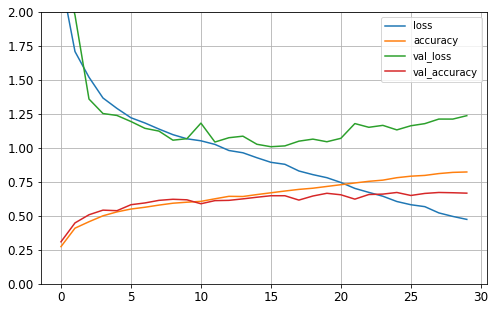

In [76]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [77]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred

array([3, 6, 2, ..., 0, 3, 3])

In [78]:
print("Accuracy score:{:.3f}".format(accuracy_score(y_test, y_pred))) # calculate accuracy score
print("Precision score:{:.3f}".format(precision_score(y_test, y_pred, average="weighted"))) # calculate precision score
print("Recall score:{:.3f}".format(recall_score(y_test, y_pred, average="weighted"))) # calculate recall score
print("F1 score:{:.3f}".format(f1_score(y_test, y_pred, average="weighted"))) # calculate F1 score

Accuracy score:0.661
Precision score:0.653
Recall score:0.661
F1 score:0.654


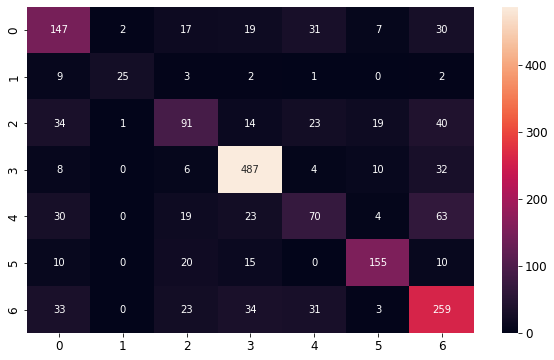

In [79]:
import seaborn as sns
plt.figure(1, figsize=(10,6))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='')

From the heatmap, it can be seen that CNN model is doing quite well on classifying happy, neutral, angry and surprised but not so well on disgusted, fearful and sad. The Accuracy score is 0.661, 
Precision score is 0.653, Recall score is 0.661 and F1 score is 0.654.

### **Prediction on Public and Private Test**

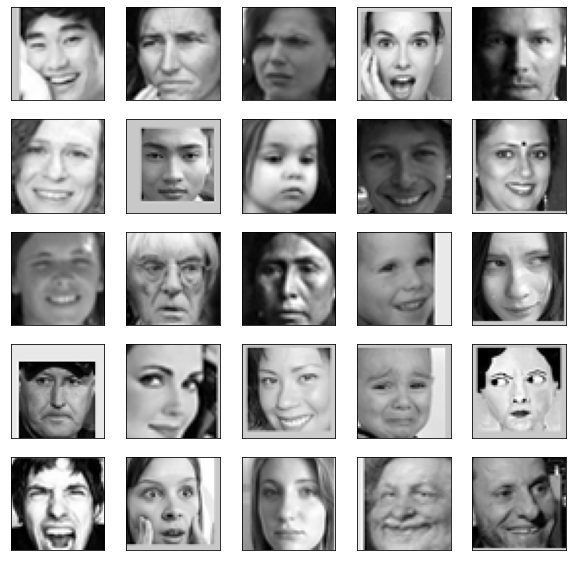

In [80]:
# show public images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public_face[i], cmap='gray')
plt.show()

In [81]:
images_test_public = images_test_public_face[..., np.newaxis]
images_test_private = images_test_private_face[..., np.newaxis]

In [82]:
print(images_test_public.shape)
print(images_test_private.shape)

(1136, 48, 48, 1)
(1153, 48, 48, 1)


In [83]:
# make prediction on PUBLIC test
public_pred_cnn = np.argmax(model.predict(images_test_public), axis=-1)
private_pred_cnn = np.argmax(model.predict(images_test_private), axis=-1)

print(public_pred_cnn)
print(private_pred_cnn)

[3 4 0 ... 3 4 3]
[4 3 3 ... 6 3 2]


In [84]:
# Generate CSV for public test

f = open(join(dataset_directory, '46727000_deep_predictions_cnn_public.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_public_face)):
  f.write(str(i) + f',{public_pred_cnn[i]}\n') 
f.close()


In [85]:
# Generate CSV for private test

f = open(join(dataset_directory, '46727000_deep_predictions_cnn_private.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_private_face)):
  f.write(str(i) + f',{private_pred_cnn[i]}\n') 
f.close()


### **Training the model for OOD**

In [86]:
# train test split

X = images_all 
y = labels_all
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [87]:
X_valid, X_train = X_train_full[:1000], X_train_full[1000:]
y_valid, y_train = y_train_full[:1000], y_train_full[1000:]

In [88]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [89]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(7662, 48, 48, 1)
(2166, 48, 48, 1)
(7662,)
(2166,)
(1000, 48, 48, 1)
(1000,)


In [90]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
train_datagen.fit(X_train)
train_datagen.fit(X_valid)
train_datagen.fit(X_test)

In [91]:
keras.backend.clear_session()
tf.random.set_seed(42)

model_ood = keras.models.Sequential([
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),input_shape=(48, 48, 1),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax")
])


In [92]:
model_ood.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [93]:
model_ood.compile(loss="sparse_categorical_crossentropy", 
              optimizer='nadam',
              metrics=["accuracy"])

history_ood=model_ood.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
model_ood.evaluate(X_test, y_test)

Epoch 1/30
240/240 [==============================] - 9s 26ms/step - loss: 1.6719 - accuracy: 0.3986 - val_loss: 2.3896 - val_accuracy: 0.3020
Epoch 2/30
240/240 [==============================] - 6s 23ms/step - loss: 1.3731 - accuracy: 0.4995 - val_loss: 1.5358 - val_accuracy: 0.4510
Epoch 3/30
240/240 [==============================] - 5s 23ms/step - loss: 1.2254 - accuracy: 0.5519 - val_loss: 1.0837 - val_accuracy: 0.6140
Epoch 4/30
240/240 [==============================] - 6s 23ms/step - loss: 1.1554 - accuracy: 0.5841 - val_loss: 1.0435 - val_accuracy: 0.6310
Epoch 5/30
240/240 [==============================] - 6s 23ms/step - loss: 1.0986 - accuracy: 0.6005 - val_loss: 0.9905 - val_accuracy: 0.6420
Epoch 6/30
240/240 [==============================] - 6s 23ms/step - loss: 1.0434 - accuracy: 0.6168 - val_loss: 0.9858 - val_accuracy: 0.6430
Epoch 7/30
240/240 [==============================] - 5s 23ms/step - loss: 1.0081 - accuracy: 0.6322 - val_loss: 0.9097 - val_accuracy: 0.6630

[1.090907096862793, 0.7132964134216309]

### **Evaluation**

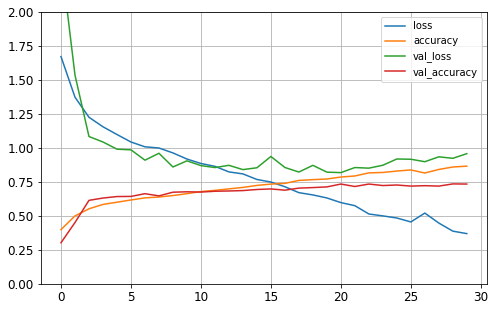

In [94]:
pd.DataFrame(history_ood.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [95]:
y_pred_ood = np.argmax(model_ood.predict(X_test), axis=-1)
y_pred_ood

array([4, 0, 6, ..., 5, 3, 3])

In [96]:
print("Accuracy score:{:.3f}".format(accuracy_score(y_test, y_pred_ood))) # calculate accuracy score
print("Precision score:{:.3f}".format(precision_score(y_test, y_pred_ood, average="weighted"))) # calculate precision score
print("Recall score:{:.3f}".format(recall_score(y_test, y_pred_ood, average="weighted"))) # calculate recall score
print("F1 score:{:.3f}".format(f1_score(y_test, y_pred_ood, average="weighted"))) # calculate F1 score

Accuracy score:0.713
Precision score:0.711
Recall score:0.713
F1 score:0.704


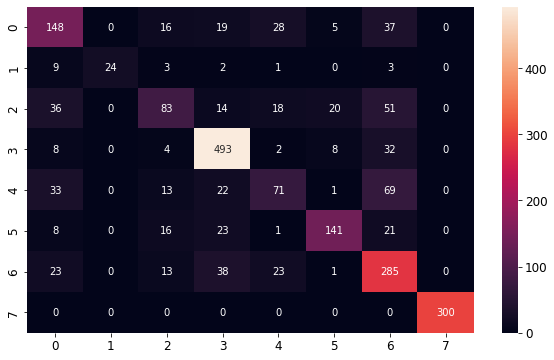

In [97]:
import seaborn as sns
plt.figure(1, figsize=(10,6))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_ood), annot=True, fmt='')

From the heatmap, it can be seen that CNN model is doing quite well on classifying happy, neutral, angry and surprised but not so well on disgusted, fearful and sad. It is 100% correct in classifying MNIST data. Accuracy score is 0.713, Precision score is 0.711, Recall score is 0.713 and F1 score is 0.704.




### **Prediction on Public and Private Test**

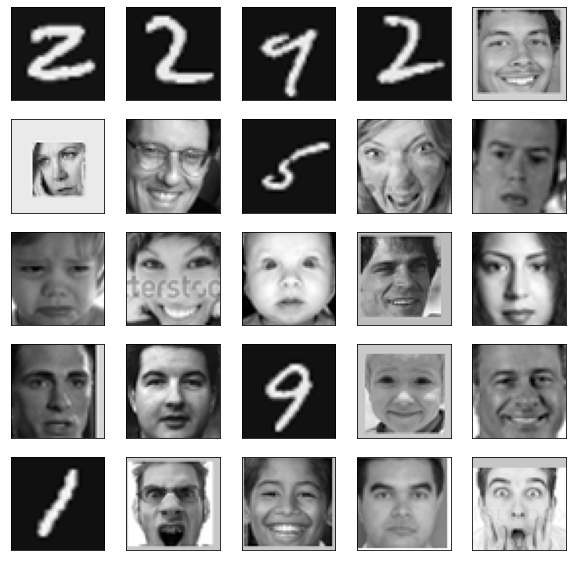

In [98]:
# show public images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public_ood[i], cmap='gray')
plt.show()

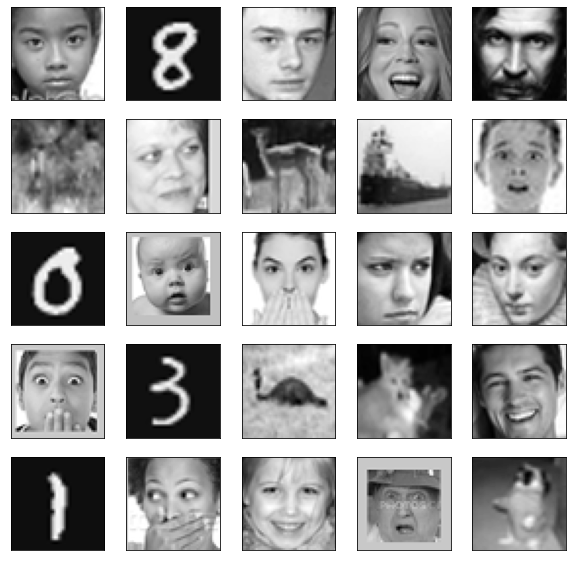

In [99]:
# show private images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_private_ood[i], cmap='gray')
plt.show()

In [100]:
images_test_public_ood = images_test_public_ood[..., np.newaxis]
images_test_private_ood = images_test_private_ood[..., np.newaxis]

In [101]:
print(images_test_public_ood.shape)
print(images_test_private_ood.shape)

(1636, 48, 48, 1)
(1753, 48, 48, 1)


In [102]:
# make prediction on PUBLIC test
public_pred_cnn_ood = np.argmax(model.predict(images_test_public_ood), axis=-1)
private_pred_cnn_ood = np.argmax(model.predict(images_test_private_ood), axis=-1)

print(public_pred_cnn_ood)
print(private_pred_cnn_ood)

[3 4 4 ... 2 4 4]
[6 6 6 ... 4 2 2]


In [103]:
# Generate CSV for public test

f = open(join(dataset_directory, '46727000_deep_predictions_cnn_public_ood.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_public_ood)):
  f.write(str(i) + f',{public_pred_cnn_ood[i]}\n') 
f.close()


In [104]:
# Generate CSV for private test

f = open(join(dataset_directory, '46727000_deep_predictions_cnn_private_ood.csv'), 'w') 
f.write('ID,Predictions\n')
for i in range(len(images_test_private_ood)):
  f.write(str(i) + f',{private_pred_cnn_ood[i]}\n') 
f.close()


### **Discussion on other Deep Learning Models trained**

As discussed in the selected model session above, besides i have trained models with different combination of convolution layers, pooling layers, dropout layers, dense layers, etc. and trying different activations, I also trained a ResNet-34 model with the following structure. 

<img src="https://i.ibb.co/7RKrzxT/Screenshot-2022-06-01-at-9-47-59-PM.png" alt="Screenshot-2022-06-01-at-9-47-59-PM" border="0">

However, it does not outperform the selected model. The accuracy is 63% compare to 66% of the selected model.


## **Comparison between selected Conventional ML Model and Deep Learning Model**

It is observed that both SVM and CNN model performed better on OOD dataset than Face Only dataset. In general, selectted CNN model outperformed selected conventional ML model (CVM classifier) by around 10% in evaluation socres as summarised in the table below.


| Dataset   | Selected Model | Accuracy | Precision | Recall | F1 Score |
|-----------|----------------|----------|-----------|--------|----------|
| Face Only | SVM            | 0.56     | 0.55      | 0.56   | 0.54     |
| Face Only | CNN            | 0.66     | 0.65      | 0.66   | 0.65     |
| OOD       | SVM            | 0.6      | 0.59      | 0.6    | 0.59     |
| OOD       | CNN            | 0.71     | 0.71      | 0.71   | 0.7      |

# **Conclusions**
The selected conventional ML model was a Support-Vector Machines (SVM)classifier which acheived accuracy of 63% for Face Only and 72% for OOD in public test, and accuracy of 64% for Face Only and 69% for OOD in private test. On the other hand, the selected deep learning model was a Convolutional Neural Networks (CNN) model which achieved accuracy of 66% for Face Only and 74% for OOD in public test and accuracy of 63% for Face Only and 73% for OOD in private test. Overall, the accuracy for OOD is greater than that for Face Only. It is possibly due to the fact that I trained the same conventional and deep learning model for both scenario and didn't adjust for the difference in images handling approaches for these two datasets.

This dataset is lack of disgusted emotions images and thus, the predictions on disgusted emotions are poor for both conventional machine learning and deep learning models. Prior to training conventional ML models, Histogram of Oriented Gradients Method was used to extract image features and achieved great improvement in accuracy. Moreover, image augmentations such as normalization, rotation, width_shift, height_shift, shear, zoom, and horizontal flip were used to transform the image before model training. 

Images other than MNIST such as animals and public transportation were included in private test (OOD), resulted in drop in accuracy for both conventional and deep learning models. To avoid this, images from different categories should be included in training. 

**Possible Solutions:**
1. To improve accuracy, I should include more images of disgusted emotions and create a more balanced training set. Should try to train with a larger dataset.
2. Overfitting problem was observed in both conventional and deep learning model. To avoid overitting, I should add early stopping in the deep learning models.
3. To correct the learning rate divergency, I should apply a learning rate schedule in training deep learning models.
4. To improve accuracy in both Face Only and OOD, I should use different methods to train the models and handle image preprocessing differently. 

**Kaggle Position:**  
23/65 in Face Only (Public)\
32/53 in Face Only (Private)\
16/49 in OOD (Public)\
17/53 in OOD (Private)
